# TP4 Support Vector Machine

Mulapi Tita Ketsia

### 0. Importation des libraiires

In [263]:
import numpy as np
import sklearn.datasets as data
import matplotlib.pyplot as plt

In [264]:
def mesh(X, h = 0.02):
    x_min , x_max = X[:, 0]. min() - .5, X[:, 0]. max() + .5
    y_min , y_max = X[:, 1]. min() - .5, X[:, 1]. max() + .5
    xx , yy = np.meshgrid(np.arange(x_min , x_max , h), np.arange(y_min , y_max , h))
    return np.c_[xx.ravel(), yy.ravel()], xx , yy

### 1. Problème Jouet

In [265]:
'''
Les n nombres de 300 points que contiennent les classes

'''
n = 300
sigma = 0.3
a = np.array([-1,-1])
b = np.array([1,1])

X1 = sigma * np.random.randn(n,2) + a
X2 = sigma * np.random.randn(n,2) + b

X = np.concatenate((X1,X2),axis=0)

#### Etiquetez les points pour pouvoir entrainer un SVM par la suite

In [266]:
y = np.concatenate((np.zeros((n)),np.ones((n))), axis = 0)

#### Affichez le nuage de points.

In [267]:
plt.scatter(X1[:,0],X1[:,1],c = 'r', s= 7)
plt.scatter(X2[:,0],X2[:,1],c = 'blue', s= 7)
plt.show()

### On souhaite vérifier les propriétés des SVMs à partir de la solution du problème d’optimisation obtenue sur ces données synthétiques :

##### Entrainez un SVM linéaire avec l’implémentation SVC de Scikit-learn. Proposez pour cela une paramétrisation pertinente pour vous assurer que :

◦ le modèle est bien linéaire

◦ qu’il n’y a pas de données d’apprentissage mal classées

Justifiez brièvement cette paramétrisation

In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn import metrics
import numpy as np

In [269]:
model = SVC(C=10000, kernel="linear", random_state=0, tol=1e-5).fit(X,y)

In [270]:
model

SVC(C=10000, kernel='linear', random_state=0, tol=1e-05)

. Du modèle appris, récupérez :

    ◦ les indices des vecteurs supports


In [271]:
indices_VS = model.support_

In [272]:
indices_VS

array([ 56,  92, 498], dtype=int32)

In [273]:
values_VS = model.support_vectors_

In [274]:
values_VS

array([[-0.16835634, -0.78206771],
       [-0.47476291, -0.31967509],
       [ 0.4648178 ,  0.29152578]])

    ◦ le vecteur α solution du problème dual

In [275]:
alpha = model.dual_coef_[0]

In [276]:
alpha

array([-0.02731294, -1.56467511,  1.59198804])

In [277]:
alpha

array([-0.02731294, -1.56467511,  1.59198804])

    ◦ le biais b

In [278]:
b = model.intercept_

In [279]:
b

array([0.02126828])

. À partir de ces valeurs, calculez le vecteur w

In [280]:
def get_w(d,indices_VS,alpha,X):
    '''
    d : nombre de dimension du problème
    W : Les paramètres du modèles
    alpha : le vecteur des 
    '''
    W = np.zeros(d)
    for i in range(len(indices_VS)):
        W += alpha[i] * X[indices_VS[i]] * y[indices_VS[i]]
    return W

In [281]:
W = get_w(X.shape[1],indices_VS,alpha,X)

In [282]:
W

array([0.73998439, 0.46410555])

In [283]:
def h(X, W, b, indx):
    '''
    C'est la fonction de décision
    '''
    return W.T@X[indx]+b

In [284]:
def verification(X, w, b, indices_VS):
    '''
    
    '''
    for i in range(len(indices_VS)):
        print(h(X, w, b, indices_VS[i]))

In [285]:
verification(X, W, b, indices_VS)

[-0.46627474]
[-0.47841184]
[0.50052493]


On voit bien que, en appliquant la frontière de décision, nos valeurs, varient entre -1 et +1

    . Sur la même figure, faites ressortir les points supports

/tmp/ipykernel_4256/3866725264.py:18: UserWarning: The following kwargs were not used by contour: 's'
  ax.contour(XX, YY, Z, levels=[-1, 0, 1], alpha=0.8, s=100, cmap=plt.cm.coolwarm)


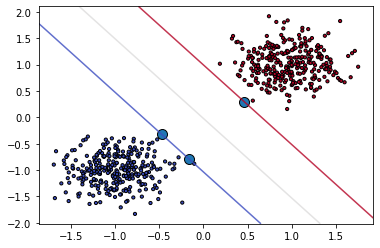

In [286]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.coolwarm, edgecolors="k")

ax = plt.gca()

xlim = ax.get_xlim()
ylim = ax.get_ylim()


xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)

YY, XX = np.meshgrid(yy, xx)

xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, levels=[-1, 0, 1], alpha=0.8, s=100, cmap=plt.cm.coolwarm)
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, cmap=plt.cm.coolwarm, edgecolors="k")

plt.show()

    . Que devient cette figure lorsque la variance des classes Gaussiennes devient plus grande ? Analysez et commentez ce qu’il se passe.

Logiquement, plus la variance des classes qui suivent une loi de gausse est grande et plus les données se mélangent. Conclusion, on aura beaucoup plus de points de supports.

### 2. Reconnaissance de chiffres manuscrits

On souhaite mettre en œuvre un SVM pour la classification de chiffres manuscrits. Tout d’abord :

. Chargez la base mnist_784 du site Open ML 1 en utilisant la fonction fetch_openml de scikitlearn 2
. Prenez le temps de bien lire la description de la base pour comprendre de quoi il s’agit.

In [287]:
from sklearn.datasets import fetch_openml

In [288]:
X, y = fetch_openml('mnist_784', return_X_y=True, version=1, as_frame=False)

. Séparez les 60000 premières données pour l’apprentissage des 10000 dernières pour le test

In [289]:
from sklearn.model_selection import StratifiedShuffleSplit

In [290]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [291]:
len(X_train)

63000

In [292]:
len(X_test)

7000

In [293]:
len(y_train)

63000

In [294]:
X_test = np.concatenate([X_test,X_train[60000:63000]])

In [295]:
len(X_test)

10000

In [296]:
y_test = np.concatenate([y_test,y_train[60000:63000]])

In [297]:
len(y_train)

63000

In [298]:
X_train, y_train = X_train[:60000],y_train[:60000]

In [299]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

60000 60000
10000 10000


-> On a donc 60000 données d'entrianement et 10000 données de test!

. Isolez les classes correspondant aux chiffres ’1’ (qui sera la classe positive) et aux chiffres ’8’ (qui sera la classe négative)

In [300]:
plt.imshow(X_train[5].reshape(28,28),cmap="gray")

In [344]:
# p : classe positive
# n : classe négative
# n_p : nombre positif
# n_n : nombre negatif
n_p = 1
n_n = 8

In [345]:
def get_neg_pos_class(n_p,n_n,X,y):
    Xp, yp = [], []
    Xn, yn = [], []
    for i in range(len(y)):
        if y[i]== str(n_p):
            Xp.append(X[i])
            yp.append(y[i])
        elif y[i]==str(n_n):
            Xn.append(X[i])
            yn.append(y[i])
    return Xp, yp, Xn, yn

In [346]:
Xp_app, yp_app, Xn_app, yn_app = get_neg_pos_class(n_p,n_n,X_train,y_train)

In [347]:
Xp_test, yp_test, Xn_test, yn_test = get_neg_pos_class(n_p,n_n,X_test,y_test)

In [348]:
len(yp_app)

6733

In [349]:
len(yn_app)

5863

In [350]:
6733+5863

12596

In [351]:
X_app = np.concatenate([Xp_app,Xn_app])
y_app = np.concatenate([yp_app,yn_app])
X_dec = np.concatenate([Xp_test,Xn_test])
y_dec = np.concatenate([yp_test,yn_test])

In [352]:
len(y_app)

12596

In [353]:
len(X_dec)

2106

. Sur un même graphique, affichez 10 imagettes de la base d’apprentissage, 5 de la classe positive et 5 de la classe négative. Utilisez pour cela la fonction imshow de PyPlot 3

In [354]:
12596-5

12591

In [355]:
imagette_positives = [i.reshape(28,28) for i in X_app[:5]]
imagette_negatives = [i.reshape(28,28) for i in X_app[12591:]]
imagettes = np.concatenate((imagette_positives,imagette_negatives))
fig, axs = plt.subplots(nrows=2, ncols=5)
print('Les 10 imagettes de la classe d\'apprentissage 5 positives et 5 négatives')
for ax, imagette in zip(axs.flat, imagettes):
    ax.imshow(imagette,cmap='gray')
plt.show()

Les 10 imagettes de la classe d'apprentissage 5 positives et 5 négatives


Maintenant, pour apprendre un classifieur linéaire SVM sur ce problème de classification binaire :

1) Utilisez une procédure de validation croisée sur l’ensemble d’apprentissage pour déterminer la
meilleure valeur du paramètre C à utiliser pour cette base de données.

In [313]:
C_params = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [314]:
from sklearn.model_selection import cross_val_score

#### By me

In [315]:
def get_best_hyperparam(C_params, X_app, y_app):
    print("mean (+/-std):\n")
    for param in C_params :
        model = SVC(kernel='linear', C=param, random_state=42)
        score = cross_val_score(model, X_app, y_app, cv=6)
        moy = np.mean(score)
        et = np.std(score)
        print("%0.3f (+/-%0.03f) pour %r"%(moy, et * 2, param))

In [316]:
get_best_hyperparam(C_params, X_app, y_app)

mean (+/-std):

0.982 (+/-0.006) pour 0.0001
0.977 (+/-0.007) pour 0.001
0.978 (+/-0.007) pour 0.01
0.978 (+/-0.007) pour 0.1
0.978 (+/-0.007) pour 1
0.978 (+/-0.007) pour 10
0.978 (+/-0.007) pour 100
0.978 (+/-0.007) pour 1000
0.978 (+/-0.007) pour 10000


-> on voit que 0.0001 semble donner une bonne moyenne de performance avec p lelus faible écart-type de la performance alors que 1000 donne moins bien que ça (mais pas mal) avce un bon écart type. 

Choisir l'un ou l'autre ne dérange pas selon qu'on veut travailler en faisant soft ou du hard margin.

Dans mon cas, je choisis 100.

2) Une fois la valeur de C retenue, relancez l’apprentissage d’un SVM sur la base d’apprentissage
complète.

In [317]:
model = SVC(kernel='linear', C=100, random_state=42)
model = model.fit(X_app,y_app)

In [318]:
model

SVC(C=100, kernel='linear', random_state=42)

. Testez le classifieur obtenu :

In [319]:
y_pred = model.predict(X_dec)

. Calculez et affichez le taux de bonne classification sur la base de test

In [320]:
# rappel
print(len(Xp_test), len(Xn_test), len(X_dec))

1144 962 2106


In [321]:
print(y_dec[y_dec!=y_pred])

['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8'
 '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8']


In [322]:
print(len(y_dec[y_dec!=y_pred]))

49


In [323]:
str(100-(len(y_dec[y_dec!=y_pred])*100)/len(y_dec))+" %"

'97.673314339981 %'

-> Donc on a fait 97.6% de bonne prediction

preuves avec sklearn :

In [324]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score

In [325]:
print(accuracy_score(y_dec, y_pred))

0.9767331433998101


◦ Affichez 25 exemples de données mal classées

In [326]:
def get_bad_pred(y_pred,y_dec):
    X_bad = []
    for i in range(len(y_pred)):
        if(y_pred[i]!=y_dec[i]):
            X_bad.append(X_dec[i])
    return X_bad

In [327]:
X_bad = get_bad_pred(y_pred,y_dec)

25 imagettes mal prédites


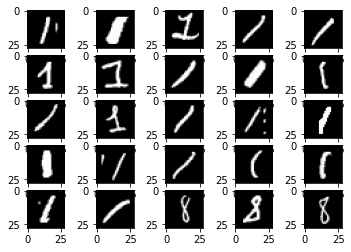

In [328]:
imagettes25 = [i.reshape(28,28) for i in X_bad[:25]]
fig, axs = plt.subplots(nrows=5, ncols=5)
print('25 imagettes mal prédites')
for ax, imagette in zip(axs.flat, imagettes25):
    ax.imshow(imagette,cmap='gray')
plt.show()

◦ Calculez et affichez la matrice de confusion

Text(0.5, 1.0, 'Matrice de confusion SVM Linear')

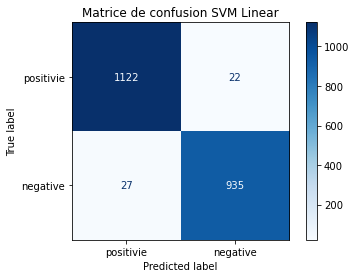

In [329]:
class_names = ['positivie', 'negative']
disp = plot_confusion_matrix(model, X_dec, y_dec,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title('Matrice de confusion SVM Linear')

Après évaluation du modèle, on peut conclure que : notre modèle décide bien car on a fait très peu d'erreur (49 mauvaises predictions) et un bon score sur nos données de test du fait que l'on a retrouvé toutes les predictions tel qu'elle doivent être !!!

Et c'est normal car on forcé le modèle à être biaisé du fait qu'on lui  a donnée un jeux dans cet ordre (positive, negatif)

### 3. Relancez toute la procédure avec une autre paire de chiffres.

##### Je choisis 3 et 7

In [356]:
# p : classe positive
# n : classe négative
# n_p : nombre positif
# n_n : nombre negatif

n_p = 3
n_n = 7

Xp_app, yp_app, Xn_app, yn_app = get_neg_pos_class(n_p,n_n,X_train,y_train)
Xp_test, yp_test, Xn_test, yn_test = get_neg_pos_class(n_p,n_n,X_test,y_test)

X_app = np.concatenate([Xp_app,Xn_app])
y_app = np.concatenate([yp_app,yn_app])
X_dec = np.concatenate([Xp_test,Xn_test])
y_dec = np.concatenate([yp_test,yn_test])

In [357]:
len(X_app)-5

12405

Les 10 imagettes de la classe d'apprentissage 5 positives et 5 négatives


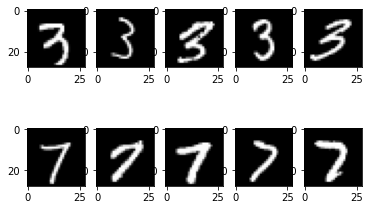

mean (+/-std):

0.980 (+/-0.004) pour 0.0001
0.979 (+/-0.004) pour 0.001
0.979 (+/-0.004) pour 0.01
0.979 (+/-0.004) pour 0.1
0.979 (+/-0.004) pour 1
0.979 (+/-0.004) pour 10
0.979 (+/-0.004) pour 100
0.979 (+/-0.004) pour 1000
0.979 (+/-0.004) pour 10000


In [358]:
imagette_positives = [i.reshape(28,28) for i in X_app[:5]]
imagette_negatives = [i.reshape(28,28) for i in X_app[12405:]]
imagettes = np.concatenate((imagette_positives,imagette_negatives))
fig, axs = plt.subplots(nrows=2, ncols=5)
print('Les 10 imagettes de la classe d\'apprentissage 5 positives et 5 négatives')
for ax, imagette in zip(axs.flat, imagettes):
    ax.imshow(imagette,cmap='gray')
plt.show()

get_best_hyperparam(C_params, X_app, y_app)

taux de bonne performance :  0.9836956521739131 %
25 imagettes mal prédites


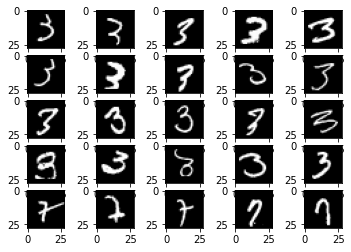

Text(0.5, 1.0, 'Matrice de confusion SVM Linear')

In [361]:
model = SVC(kernel='linear', C=0.0001, random_state=42)
model = model.fit(X_app,y_app)

y_pred = model.predict(X_dec)

print("taux de bonne performance : ", str(accuracy_score(y_dec, y_pred)) +" %")

X_bad = get_bad_pred(y_pred,y_dec)

imagettes25 = [i.reshape(28,28) for i in X_bad[:25]]
fig, axs = plt.subplots(nrows=5, ncols=5)
print('25 imagettes mal prédites')
for ax, imagette in zip(axs.flat, imagettes25):
    ax.imshow(imagette,cmap='gray')
plt.show()

class_names = ['positivie_3', 'negative_7']
disp = plot_confusion_matrix(model, X_dec, y_dec,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title('Matrice de confusion SVM Linear')

In [362]:
print(len(y_dec[y_dec!=y_pred]))

33


;comme on peut le voir sur la matrice de confusion, il y'a 33 mauvaise prediction dont 13 pour la classe positive (3) et, 20 pour l'autre.

### 4. Pour finir, vous pouvez tester l’apprentissage d’un SVM pour la classification multiclasse sur le même problème :

- Pour limiter les temps de calcul, réduisez le problème à la classification de 3 chiffres seulement,
par exemple, 0, 2 et 8

In [363]:
def get_multi_class(n_classes,X,y):
    Xcl, ycl = [], []
    datas = []
    for c in n_classes:
        for i in range(len(y)):
            if y[i]== str(c):
                Xcl.append(X[i])
                ycl.append(y[i])
        datas.append((Xcl,ycl))
        Xcl, ycl = [], []
    return datas

In [364]:
classes = [0,2,8]
datas_app = get_multi_class(classes,X_train,y_train)
datas_dec = get_multi_class(classes,X_test,y_test)

X_app1, y_app1 = datas_app[0]
X_app2, y_app2 = datas_app[1]
X_app3, y_app3 = datas_app[2]
X_dec1, y_dec1 = datas_dec[0]
X_dec2, y_dec2 = datas_dec[1]
X_dec3, y_dec3 = datas_dec[2]

X_app = np.concatenate([X_app1,X_app2,X_app3])
y_app = np.concatenate([y_app1,y_app2,y_app3])
X_dec = np.concatenate([X_dec1,X_dec2,X_dec3])
y_dec = np.concatenate([y_dec1,y_dec2,y_dec3])

In [365]:
print(len(datas_app),len(datas_dec))

3 3


In [366]:
from sklearn.svm import LinearSVC

In [367]:
print("mean (+/-std):\n")
model = LinearSVC()
score = cross_val_score(model, X_app, y_app, cv=6)
moy = np.mean(score)
et = np.std(score)
print("%0.3f (+/-%0.03f)"%(moy, et * 2))

mean (+/-std):



/home/ketsia/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/ketsia/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/ketsia/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/ketsia/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/ketsia/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to con

0.959 (+/-0.013)


/home/ketsia/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


pas mal comme modèle sans paramètre !!!

Proposez un protocole expérimental pour évaluer les performances d’un SVM linéaire sur ce
problème, avec l’implémentation de Scikit-learn.

2) Une fois la valeur de C retenue, relancez l’apprentissage d’un SVM sur la base d’apprentissage
complète.

In [368]:
model = LinearSVC()
model = model.fit(X_app,y_app)
print(model)
y_pred = model.predict(X_dec)

LinearSVC()


/home/ketsia/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


. Calculez et affichez le taux de bonne classification sur la base de test

In [369]:
print(y_dec[y_dec!=y_pred])

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '8' '8' '8' '8' '8' '8'
 '8']


In [370]:
print(len(y_dec[y_dec!=y_pred]))

127


In [371]:
print(accuracy_score(y_dec, y_pred))

0.9569345540861309


◦ Affichez 25 exemples de données mal classées

25 imagettes mal prédites


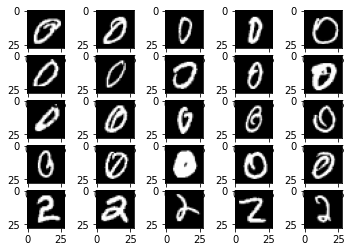

In [372]:
X_bad = get_bad_pred(y_pred,y_dec)

imagettes25 = [i.reshape(28,28) for i in X_bad[:25]]
fig, axs = plt.subplots(nrows=5, ncols=5)
print('25 imagettes mal prédites')
for ax, imagette in zip(axs.flat, imagettes25):
    ax.imshow(imagette,cmap='gray')
plt.show()

◦ Calculez et affichez la matrice de confusion

In [373]:
class_names = ['0', '1', '2']
disp = plot_confusion_matrix(model, X_dec, y_dec,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
disp.ax_.set_title('Matrice de confusion SVM Linear')

Text(0.5, 1.0, 'Matrice de confusion SVM Linear')

. Quelle stratégie multiclasse est utilisée par cette implémentation ?

Selon la librairie : 

multi_class{‘ovr’, ‘crammer_singer’}, default=’ovr’

Par defaut, la politique d'un LinearSVC est "One versus Rest" et dans notre cas également laissé ce OvsA !!